<a href="https://colab.research.google.com/github/frankzamma/AntiPiracyPlatform/blob/main/Notebook/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training e Test con DQN
In questo notebook è presente il training di Q*Bert sfruttando l'algoritmo DQN

## Download Repository

Download della repository per utilizzare le classi create su Google Colab

In [13]:
from google.colab import userdata

In [14]:
! git clone https://{userdata.get('TokenGithub')}"@github.com/amigli/Q-Bert_RL.git"

Cloning into 'Q-Bert_RL'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 325 (delta 20), reused 20 (delta 11), pack-reused 281 (from 1)
Receiving objects: 100% (325/325), 7.46 MiB | 12.52 MiB/s, done.
Resolving deltas: 100% (183/183), done.


In [15]:
%cd Q-Bert_RL

/content/Q-Bert_RL


## Installazione dei requirements

Vengono installati tutti i moduli necessari dal file requirements.txt

In [4]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 19.7 MB/s eta 0:00:00


In [5]:
!pip install ale-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.1 MB/s eta 0:00:00


In [6]:
!pip install moviepy

## Training

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

# Definizione della rete neurale feed-forward per DQN
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Definizione della classe agente DQN
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr, gamma, epsilon, epsilon_decay, buffer_size):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=buffer_size)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def act(self, state, train=True):
        state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        if train and np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_dim)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return torch.argmax(q_values, dim=1).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)

        # Preparazione batch
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)

        # Calcolo Q-valori e target
        q_values = self.model(states)
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.model(next_states).max(1)[0]
        targets = rewards + (1 - dones) * self.gamma * next_q_values

        # Ottimizzazione del modello
        self.optimizer.zero_grad()
        loss = self.criterion(q_values, targets.detach())
        loss.backward()
        self.optimizer.step()

        # Aggiornamento epsilon
        if self.epsilon > 0.01:
            self.epsilon *= self.epsilon_decay

In [34]:
import gymnasium as gym
import ale_py
from tqdm.notebook import tqdm, trange
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
from EnvironmentWrappers.ObsRewardWrapper import ObsRewardWrapper


gym.register_envs(ale_py)

learning_rate = 0.01
n_episodes = 2000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.1

env = gym.make("ALE/Qbert-ram-v5")
env =  ObsRewardWrapper(env)
env = RecordEpisodeStatistics(env, buffer_length=n_episodes)
obs, info = env.reset()

state_dim = obs.shape[0]
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, buffer_size=10000)

# TRAINING
batch_size = 64
num_episodes = 3000
for episode in trange(n_episodes, desc="Training Progress"):
    obs, info = env.reset()
    done = False

    total_reward = 0
    while not done:
        action = agent.act(obs, True)
        next_obs, reward, terminated, truncated, info = env.step(action)

        done =  terminated or truncated

        agent.remember(obs, action, reward, next_obs, done)
        obs = next_obs
        total_reward += reward
        agent.replay(batch_size)

    tqdm.write(f"Episode: {episode + 1}, Total Reward: {total_reward}")

env.close()


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

Episode: 1, Total Reward: 2
Episode: 2, Total Reward: 23
Episode: 3, Total Reward: 31
Episode: 4, Total Reward: 10
Episode: 5, Total Reward: 20
Episode: 6, Total Reward: 0
Episode: 7, Total Reward: 2
Episode: 8, Total Reward: 2
Episode: 9, Total Reward: 10
Episode: 10, Total Reward: 16
Episode: 11, Total Reward: 20
Episode: 12, Total Reward: 10
Episode: 13, Total Reward: 14
Episode: 14, Total Reward: 6
Episode: 15, Total Reward: 0
Episode: 16, Total Reward: 4
Episode: 17, Total Reward: 12
Episode: 18, Total Reward: 10
Episode: 19, Total Reward: 10
Episode: 20, Total Reward: 16
Episode: 21, Total Reward: 10
Episode: 22, Total Reward: 20
Episode: 23, Total Reward: 16
Episode: 24, Total Reward: 14
Episode: 25, Total Reward: 20
Episode: 26, Total Reward: 20
Episode: 27, Total Reward: 20
Episode: 28, Total Reward: 20
Episode: 29, Total Reward: 20
Episode: 30, Total Reward: 20
Episode: 31, Total Reward: 29.5
Episode: 32, Total Reward: 12
Episode: 33, Total Reward: 14
Episode: 34, Total Rewar

AttributeError: 'DQNAgent' object has no attribute 'training_error'

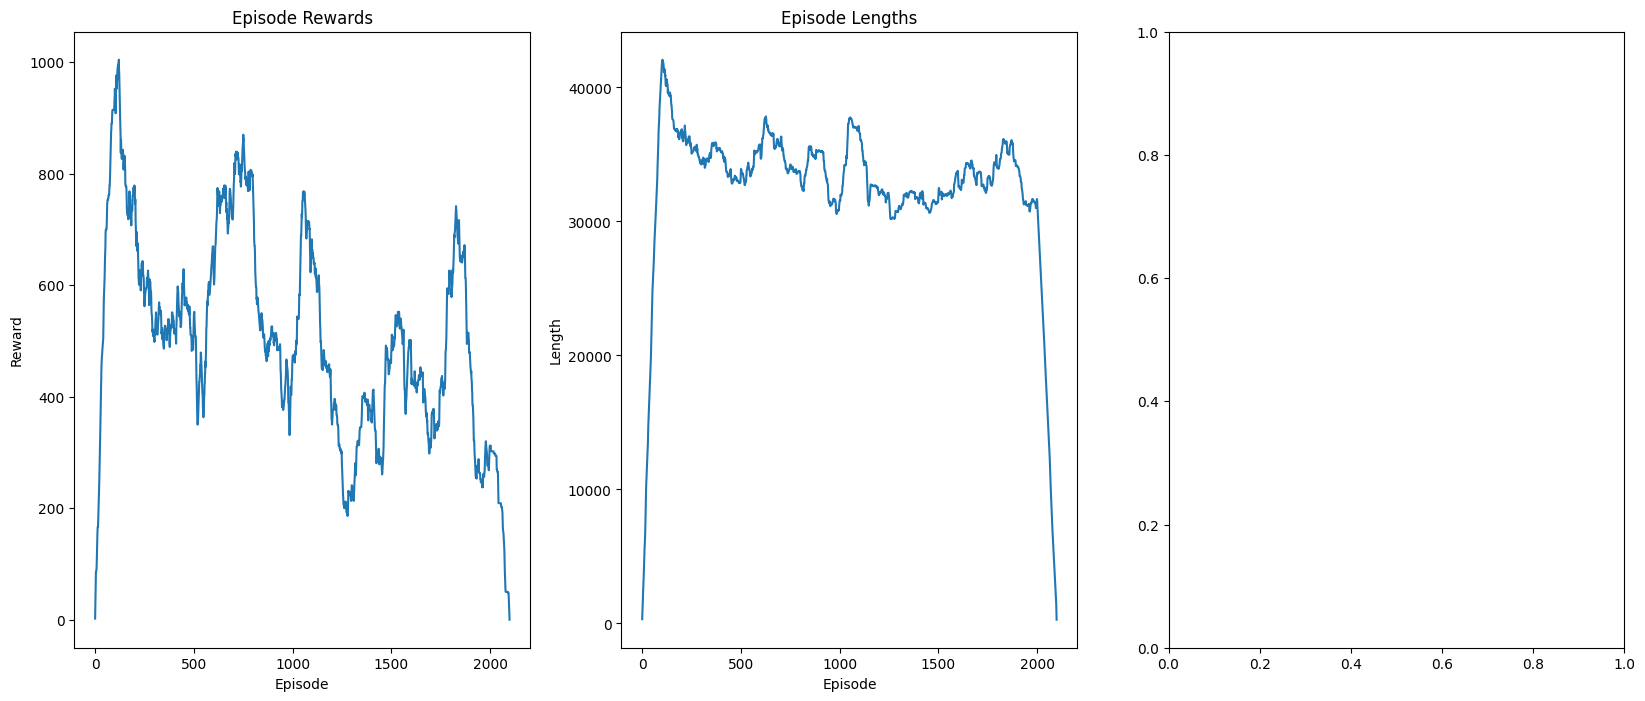

In [35]:
from matplotlib import pyplot as plt
import numpy as np

# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# np.convolve will compute the rolling mean for 100 episodes

axs[0].plot(np.convolve(env.return_queue, np.ones(100)))
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(np.convolve(env.length_queue, np.ones(100)))
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length")

axs[2].plot(np.convolve(agent.training_error, np.ones(100)))
axs[2].set_title("Training Error")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()

# Utilizzo Policy

Di seguito viente utilizzata la policy precedentemente calcolata per registrare degli episodi

In [39]:
num_eval_episodes = 10

env = gym.make("ALE/Qbert-ram-v5", render_mode="rgb_array")
env =  ObsRewardWrapper(env)
env = RecordVideo(env, video_folder="videos_first", name_prefix="eval",
                  episode_trigger=lambda x: True)
env = RecordEpisodeStatistics(env, buffer_length=num_eval_episodes)


for episode_num in range(num_eval_episodes):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.act(obs, False)
        next_obs, reward, terminated, truncated, info = env.step(action)
        obs =  next_obs

        done = terminated or truncated
env.close()

print(f'Episode time taken: {env.time_queue}')
print(f'Episode total rewards: {env.return_queue}')
print(f'Episode lengths: {env.length_queue}')

print("Training terminato")

Episode time taken: deque([0.308665, 0.30871, 0.302922, 0.307404, 0.308709, 0.321027, 0.307911, 0.303925, 0.304585, 0.306123], maxlen=10)
Episode total rewards: deque([-4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], maxlen=10)
Episode lengths: deque([279, 279, 279, 279, 279, 279, 279, 279, 279, 279], maxlen=10)
Training terminato


AttributeError: 'DQNAgent' object has no attribute 'training_error'

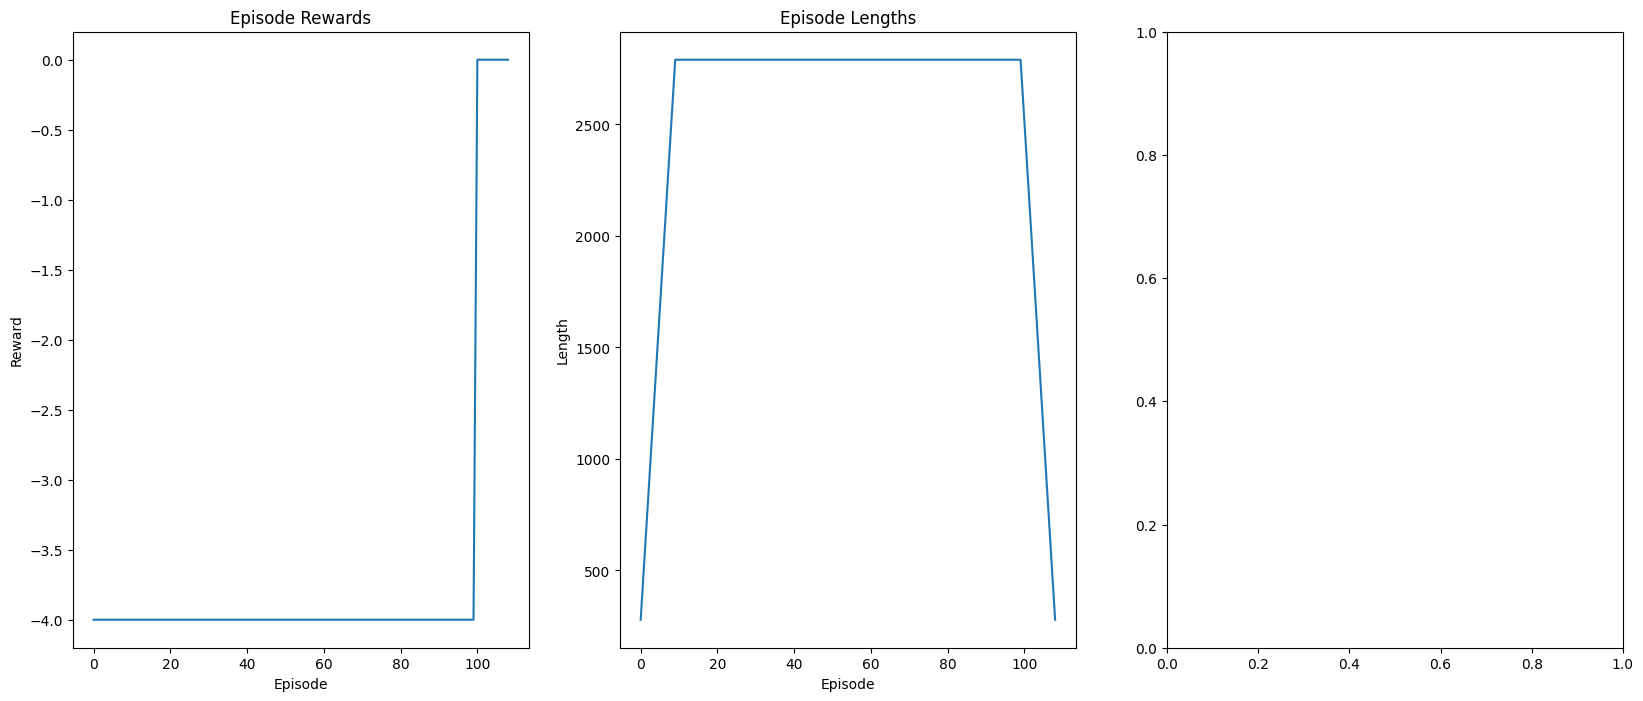

In [38]:
from matplotlib import pyplot as plt
import numpy as np

# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# np.convolve will compute the rolling mean for 100 episodes

axs[0].plot(np.convolve(env.return_queue, np.ones(100)))
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(np.convolve(env.length_queue, np.ones(100)))
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length")

axs[2].plot(np.convolve(agent.training_error, np.ones(100)))
axs[2].set_title("Training Error")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()